# This notebook calculates the Fisher matrix for various primordial trispectra

In [1]:
import numpy as np
import vegas
import matplotlib.pyplot as plt

from trispectra import *
from powerspectrum import *

from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy import interpolate as intp
from joblib import Parallel,  delayed

%matplotlib inline

plt.rcParams.update({'font.size': 12})

n_jobs=-1 #define the number of threads to be used (-1 == all available)

In [2]:
print(As,ns,P(1))

2.1056e-09 0.9665 3.759422255898631e-08


In [3]:
zs,rs = np.genfromtxt("comovingD.dat").T

VzTotal = 4.*np.pi/3. * (rs[-1]**3-rs[0]**3)

In [4]:
def integrand(k,kmin,kmax,fn,fn2,mu,alpha0):
    Fish = np.zeros(len(k))

    k1 = kmin + (kmax-kmin)*k[:,0]
    k2 = kmin + (k1-kmin)*k[:,1]
    k3 = kmin + (k2-kmin)*k[:,2]
    k4 = kmin + (k3-kmin)*k[:,3]
    
    K12min = np.fmax(kmin,k1-k2)
    K14min = np.fmax(kmin,k1-k4)
    K12 = K12min + (k1+k2-K12min)*k[:,4]
    K14 = K14min + (k1+k4-K14min)*k[:,5]

#     bools = trianglecondition(k1,k2,K12) #to check triangle conditions
#     bools+= trianglecondition(k1,k4,K14) #but these are already satisfied by the choise of integration
#     bools+= trianglecondition(k2,k3,K14)
#     bools+= trianglecondition(k3,k4,K12)
        
    gfactor = g1(k1,k2,k3,k4,K12,K14)
    bools = gfactor < 0 #check for places where the g1 factor is negative and cannot be taken sqrt of
    
    notbools = ~bools #invert all places where conditions are violated
    
    k1 = k1[notbools] #keep only places where conditions are not violated
    k2 = k2[notbools]
    k3 = k3[notbools]
    k4 = k4[notbools]
    K12 = K12[notbools]
    K14 = K14[notbools]
    K12min = K12min[notbools]
    K14min = K14min[notbools]
    gfactor = gfactor[notbools]
    
    K13 = np.sqrt(k1*k1 + k2*k2 + k3*k3 + k4*k4 - K12*K12 - K14*K14)
    
    bools  = trianglecondition(k1,k3,K13) #check final triangle conditions and ranges
    bools += trianglecondition(k2,k4,K13)
    bools += K13 > 2*kmax
    bools += K13 < kmin

    #calculate the fisher element
    c1= fn(k1,k2,k3,k4,K12,K14,K13,mu,alpha0)
    if fn2 == fn:
        c2 = c1
    else:
        c2 = fn2(k1,k2,k3,k4,K12,K14,K13,mu,alpha0)

        
    dVol = k1*k2*k3*k4*K12*K14/np.sqrt(gfactor) * (kmax-kmin)* (k1-kmin) * (k2-kmin) * (k3-kmin) * (k1+k4-K14min) * (k1+k2-K12min)
    result = c1*c2/ (2*np.pi)**3 / (2*np.pi**4) / P(k1)/P(k2)/P(k3)/P(k4)
    result*= dVol
    
    result[bools] =0 #drop places where the last conditions are not met
    Fish[notbools] = result #write to array at the places that were not violated
    return Fish

def Fisher(kmin,kmax,fn,fn2,mu=0,alpha0=0,rtol=1e-3,verbose=0):

    @vegas.batchintegrand
    def integrandbatch(k):
        return integrand(k,kmin,kmax,fn,fn2,mu,alpha0)

    integ = vegas.Integrator([[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]])

    pre = integ(integrandbatch,nitn=10,neval=1e6,rtol=rtol)
    if verbose!=0:
        print(pre.summary())
    results = integ(integrandbatch,nitn=100,neval=1e6,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    sdev = results.sdev
    rerr = np.abs(sdev/mean)
    
    return mean*VzTotal, rerr

# %time Fisher(0.01,300,TtauNL,TtauNL,0.1,2,verbose=1)

## Calculate the Fisher matrix for the common primordial shapes (local and equilateral)

In [5]:
shapes = [TtauNL,TgNL,Teq1,Teq2,Teq3]
shapelabels = ["TtauNL","TgNL","Teq1","Teq2","Teq3"]
nshapes = len(shapes)

dataPrim = np.array(Parallel(n_jobs=n_jobs,verbose=1)([delayed(Fisher)(0.01,300,shapes[i],shapes[j],rtol=1e-3) for i in range(nshapes) for j in range(i,nshapes)]))

FishPrim = np.zeros((5,5))

a=0
for i in range(5):
    for j in range(i,5):
        FishPrim[i,j]=FishPrim[j,i]= dataPrim[a,0]
        a+=1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   50.9s remaining:   44.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished


### Below are the estimated error bars for the common shapes and their overlaps

In [6]:
[(shapelabels[i],FishPrim[i,i]**(-1/2)) for i in range(5)]

[('TtauNL', 1.7955447810326952e-07),
 ('TgNL', 0.02664640818257004),
 ('Teq1', 0.22886373072172214),
 ('Teq2', 0.2541141362741325),
 ('Teq3', 0.06082958474468089)]

In [7]:
[(shapelabels[i],shapelabels[j],FishPrim[i,j]/np.sqrt(FishPrim[i,i]*FishPrim[j,j])) for i in range(5) for j in range(i+1,5)]

[('TtauNL', 'TgNL', 1.0235145876871493e-05),
 ('TtauNL', 'Teq1', 1.2891532282221865e-05),
 ('TtauNL', 'Teq2', 1.596137340503374e-05),
 ('TtauNL', 'Teq3', 1.9179189994099464e-05),
 ('TgNL', 'Teq1', 0.14356501976097533),
 ('TgNL', 'Teq2', 0.11894703652555859),
 ('TgNL', 'Teq3', 0.06663238177873204),
 ('Teq1', 'Teq2', 0.9456422227797812),
 ('Teq1', 'Teq3', 0.65131177600036),
 ('Teq2', 'Teq3', 0.8234573923288065)]

## Let's look at the clock template

In [16]:
mus = np.concatenate((np.logspace(-2,0.5,25),np.linspace(3.2,8,10)))
shapesC = [TtauNL,TgNL,Teq1,Teq2,Teq3,TClock]
tasks= [delayed(Fisher)(0.01,300,shapesC[i],TClock,mu,2,rtol=0.001) for i in range(len(shapesC)) for mu in mus]
print(len(tasks),"tasks")
dataClock = np.array(Parallel(n_jobs=n_jobs,verbose=3)(tasks))

210 tasks


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 21.8min finished


### Below we show the errorbars for the clock shape

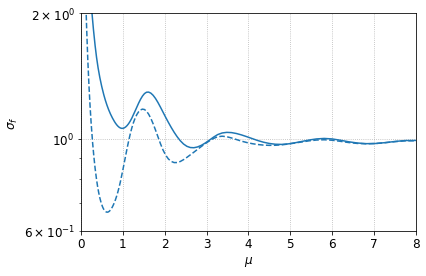

In [17]:
FishClock = np.zeros((len(mus),6,6))

FishClock[:,:-1,:-1] = FishPrim

a=0
for i in range(6):
    for j in range(len(mus)):
        FishClock[j,-1,i] = FishClock[j,i,-1] = dataClock[a,0]
        a+=1

FishClockInv = np.linalg.inv(FishClock)

#interpolate to make smooth plots
FishClockint = interpolate(mus, FishClock[:,-1,-1]**(-1/2))
FishClockInvint = interpolate(mus, FishClockInv[:,-1,-1]**(1/2))

musplot = np.logspace(-2,np.log10(8),210)
plt.semilogy(musplot,FishClockint(musplot),"--")
plt.gca().set_prop_cycle(None)
plt.semilogy(musplot,FishClockInvint(musplot))
plt.grid(linestyle=":")
plt.xlim(0,8)
plt.ylim(6e-1,2e0)
plt.xlabel("$\\mu$")
plt.ylabel("$\\sigma_f$")
plt.savefig("TClockError.pdf",format='pdf',bbox_inches="tight")
plt.show()

### and the overlaps with the common primordial shapes

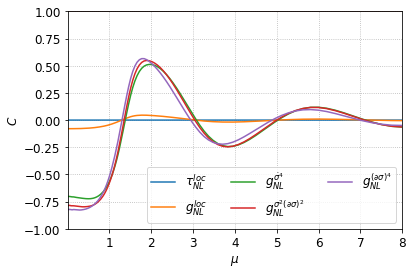

In [19]:
for shapei, shape in enumerate(shapesC):
    inter = interpolate(mus, FishClock[:,shapei,-1]/np.sqrt(FishClock[:,shapei,shapei]*FishClock[:,-1,-1]))
    plt.plot(musplot,inter(musplot))
    
plt.ylim(-1,1)
plt.xlim(mus[0],mus[-1])
plt.grid(linestyle=":")
plt.xlabel("$\\mu$")
plt.legend(['$\\tau_{NL}^{loc}$','$g_{NL}^{loc}$','$g_{NL}^{\dot{\sigma}^4}$','$g_{NL}^{\sigma^2(\partial\sigma)^2}$','$g_{NL}^{(\partial \sigma)^4}$'],ncol=3)
plt.ylabel("$C$")
plt.savefig("TClockOverlap.pdf",format='pdf',bbox_inches="tight")
plt.show()

## Now look at the intermediate template

In [ ]:
nus = np.linspace(0,1.49,12)
shapesC = [TtauNL,TgNL,Teq1,Teq2,Teq3,Tint]
tasks= [delayed(Fisher)(0.01,300,shapesC[i],Tint,nu,2,rtol=1e-4) for i in range(len(shapesC)) for nu in nus]
print(len(tasks),"tasks")
dataInt = np.array(Parallel(n_jobs=n_jobs,verbose=10)(tasks))

72 tasks


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed: 13.1min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 13.1min remaining:  1.4min
[pg-node263:31511] PMIX ERROR: UNPACK-PAST-END in file src/client/pmix_client.c at line 100
Process LokyProcess-45:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 595, in __cal

Traceback (most recent call last):
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/concurrent/futures/_base.py", line 440, in result
    self._condition.wait(timeout)
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/software/software/IPython/7.25.0-GCCcore-10.3.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


[pg-node263:31510] PMIX ERROR: UNPACK-PAST-END in file src/client/pmix_client.c at line 100
[pg-node263:31510] [[45616,1],0] ORTE_ERROR_LOG: Unreachable in file runtime/ompi_mpi_finalize.c at line 262
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/concurrent/futures/_base.py", line 440, in result
    self._condition.wait(timeout)
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/software/software/IPython/7.25.0-GCCcore-10.3.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


### below are the errorbars of the intermediate shape

/local/tmp/ipykernel_26855/1464691106.py:15: RuntimeWarning: invalid value encountered in sqrt
  plt.semilogy(nus,FishIntInv[:,-1,-1]**(1/2))


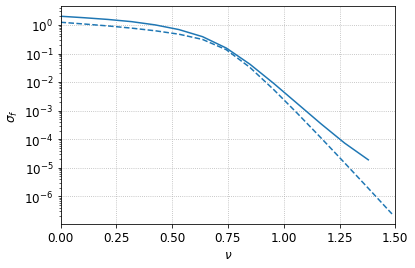

In [25]:
FishInt = np.zeros((len(nus),6,6))

FishInt[:,:-1,:-1] = FishPrim

a=0
for i in range(6):
    for j in range(len(nus)):
        FishInt[j,-1,i] = FishInt[j,i,-1] = dataInt[a,0]
        a+=1

FishIntInv = np.linalg.inv(FishInt)

plt.semilogy(nus,FishInt[:,-1,-1]**(-1/2),"--")
plt.gca().set_prop_cycle(None)
plt.semilogy(nus,FishIntInv[:,-1,-1]**(1/2))
plt.xlim(nus[0],1.5)
plt.grid(linestyle=":")
plt.xlabel("$\\nu$")
plt.ylabel("$\\sigma_f$")
plt.xticks([0,0.25,0.5,0.75,1,1.25,1.5])
plt.savefig("TIntError.pdf",format='pdf',bbox_inches="tight")
plt.show()

### and their overlaps

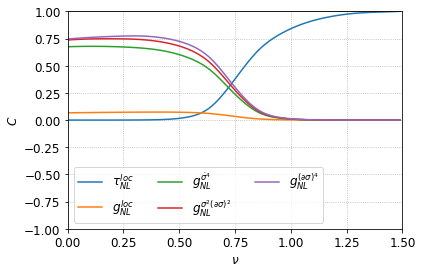

In [15]:
nusplot = np.linspace(0,1.49,100)

for shapei, shape in enumerate(shapesC):
    inter = interpolate(nus, FishInt[:,shapei,-1]/np.sqrt(FishInt[:,shapei,shapei]*FishInt[:,-1,-1]))
    plt.plot(nusplot,inter(nusplot))
    
plt.ylim(-1,1)
plt.xlim(nus[0],nus[-1])
plt.grid(linestyle=":")
plt.xlabel("$\\nu$")
plt.legend(['$\\tau_{NL}^{loc}$','$g_{NL}^{loc}$','$g_{NL}^{\dot{\sigma}^4}$','$g_{NL}^{\sigma^2(\partial\sigma)^2}$','$g_{NL}^{(\partial \sigma)^4}$'],ncol=3)
plt.ylabel("$C$")
plt.xticks([0,0.25,0.5,0.75,1,1.25,1.5])
plt.savefig("TIntOverlap.pdf",format='pdf',bbox_inches="tight")
plt.show()

## We can also check the enhanced scaling of the intermediate trispectrum  (Kalaja et al. 2020)

In [144]:
nus = np.array([0,0.25,0.5,0.74,0.75,1,1.25,3/2])
def scaling(nu):
    ks = np.array([1,10,100])
    test = [Fisher(0.01,k,Tint,Tint,nu,2,rtol=1e-1) for k in ks]
    fit = np.polyfit(np.log10(ks),np.log10(test),1)
    return fit[0]

scaling_results = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(scaling)(nu) for nu in nus]))

def analytic_scaling(nu):
    if nu < 3/4:
        return 3
    if nu == 3/4:
        return 3.1358250956502904
    if nu > 3/4:
        return 3 + 3 - 4*(3/2 - nu)
    
f = [analytic_scaling(nu) for nu in nus]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   31.5s finished


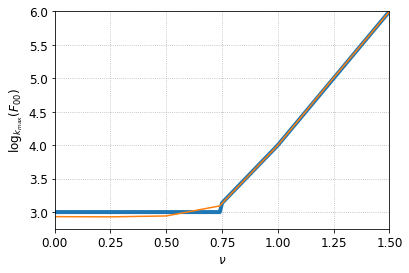

In [146]:
plt.plot(nus,f,linewidth=4)
plt.plot(nus,scaling_results)
plt.xticks([0,0.25,0.5,0.75,1,1.25,1.5])
plt.grid(linestyle=':')
plt.xlabel('$\\nu$')
plt.ylabel('$\\log_{k_{max}}(F_{00})$')
plt.ylim(2.75,6)
plt.xlim(0,3/2)
plt.savefig("EnhancedScaling.pdf",format='pdf',bbox_inches="tight")
plt.show()